<h1>BI-LSTM</h1>

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100


<h4>Importing Datasets</h4>

In [18]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={
                     'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean = df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID', 'POD_ID', 'ETD_POL_D', 'PARTY_ID',
               'PARTY_NAME', 'POD', 'CNTR_SIZE', 'CNTR_TYPE', 'RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)

    return df_filtered


In [19]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [20]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes


In [21]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))


Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting ports keys</h4>

In [22]:
def getKeyPorts(keybunch):
    keybunch_pouch = []

    # Get a dictionary with key and number of rows for each dataframe in keybunch,
    # but only if the number of rows is greater than 1000
    key_row_counts = {key: len(keybunch[key])
                      for key in keybunch if len(keybunch[key]) > 1000}

    # Sort the keys in descending order of the number of rows
    sorted_keys = sorted(key_row_counts, key=key_row_counts.get, reverse=True)

    for key in sorted_keys:
        row_count = key_row_counts[key]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)

    # Return array of keys
    return keybunch_pouch


print('Old Dataset Keybunch:')
old_df = getKeyPorts(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getKeyPorts(filtered_dataframe2)


Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h2>Selection of Key</h2>

In [23]:
# Global selection
sel_country = old_df[0]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


In [24]:
# Select features
sel_feat = ['POD', 'RATE']
# make a copy to avoid SettingWithCopyWarning
sel_feat_df = sel_df[sel_feat].copy()


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

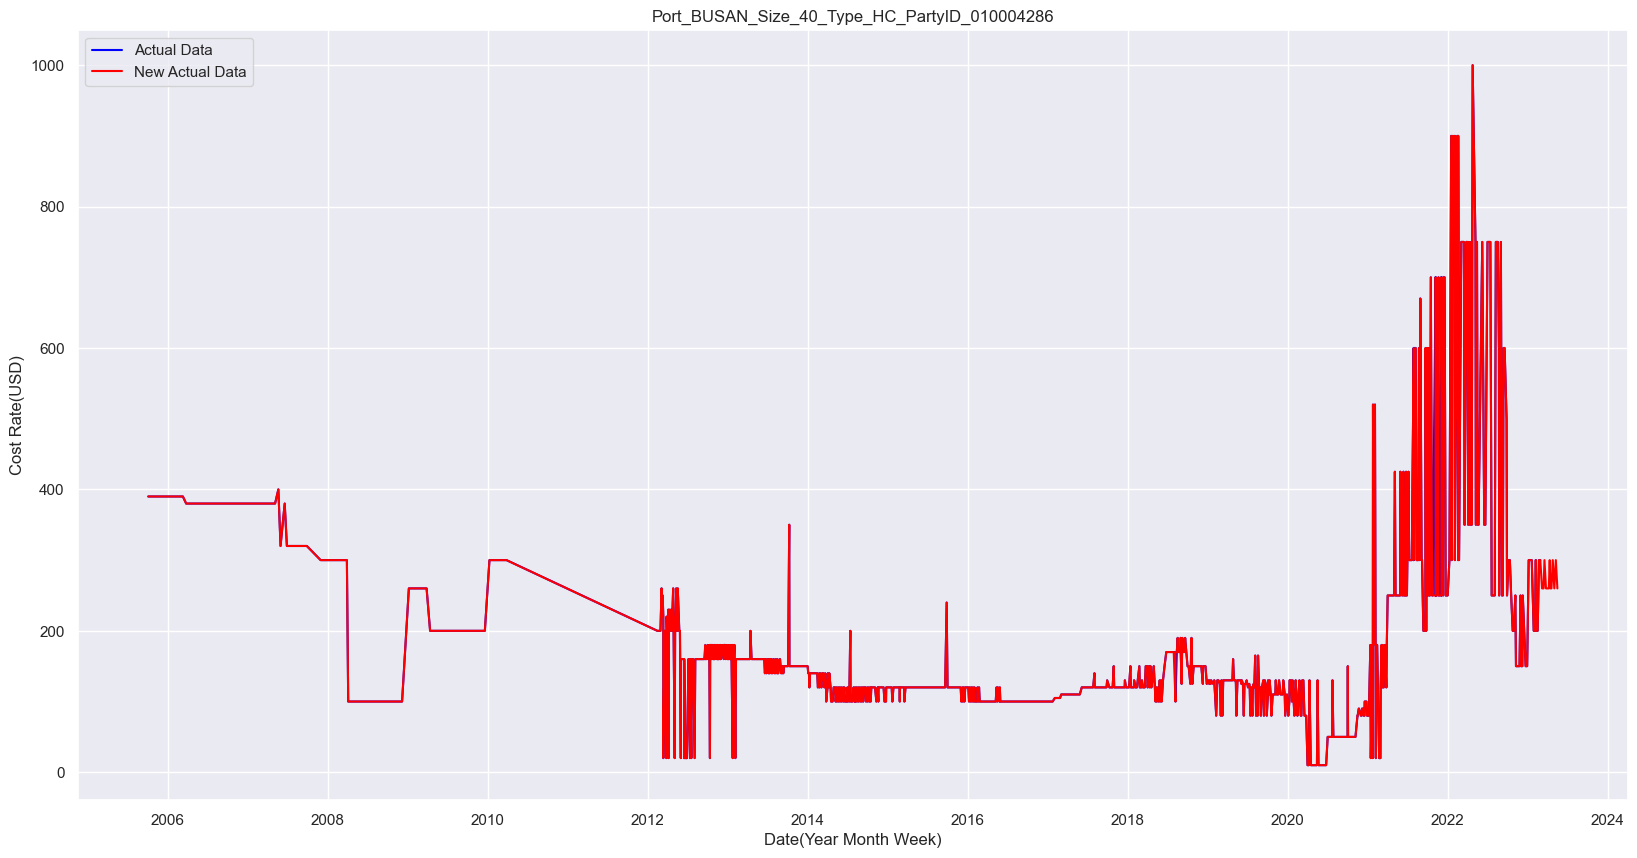

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'],
         color='blue', label="Actual Data")
plt.plot(latest_sel_df['POD'], latest_sel_df['RATE'],
         color='red', label="New Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Remove Outliers</h4>

(array([ 79.,  79., 257., 476., 246., 147.,  10., 120.,  90.,  10.,  21.,
         60.,   9.,   0.,   2.,   2.,   0.,  15.,   0.,   0.,  12.,   0.,
         46.,   0.,   0.,   0.,   7.,   0.,   0.,   1.]),
 array([  10.,   43.,   76.,  109.,  142.,  175.,  208.,  241.,  274.,
         307.,  340.,  373.,  406.,  439.,  472.,  505.,  538.,  571.,
         604.,  637.,  670.,  703.,  736.,  769.,  802.,  835.,  868.,
         901.,  934.,  967., 1000.]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of RATE')

Text(0.5, 0, 'RATE')

Text(0, 0.5, 'Frequency')

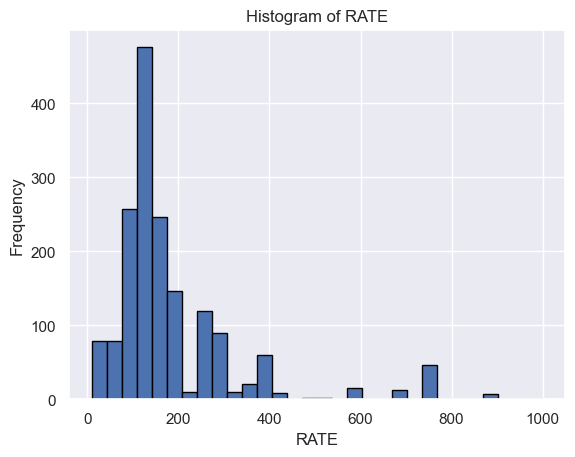

((array([-3.34574786, -3.09144144, -2.95019352, ...,  2.95019352,
          3.09144144,  3.34574786]),
  array([  10.,   10.,   10., ...,  900.,  900., 1000.])),
 (128.44807803687263, 185.65719360568386, 0.8514817671330853))

Text(0.5, 1.0, 'Q-Q plot of RATE')

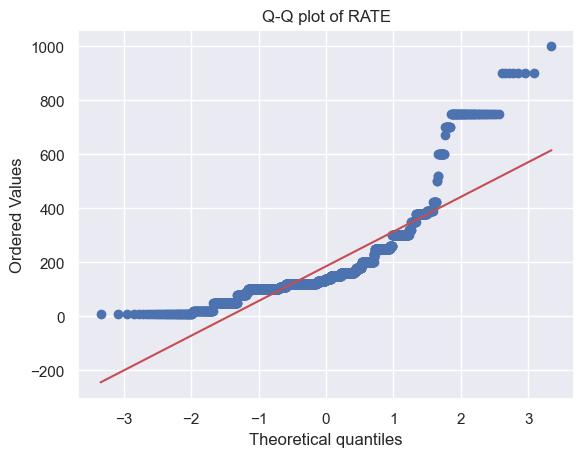

Shapiro-Wilk test:
W: 0.7252808809280396, p-value: 0.0
Anderson-Darling test:
Statistic: 139.16692731944386


Data does not look normal (reject H0)
Performing z-score of 3 to remove outliers... 




,POD,RATE
0,2005-10-03,390.0
1,2005-10-03,390.0
2,2005-10-07,390.0
3,2005-10-07,390.0
4,2005-10-14,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1623 non-null   datetime64[ns]
 1   RATE    1623 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.5 KB


In [26]:
# Histogram
plt.hist(sel_feat_df['RATE'], bins=30, edgecolor='black')
plt.title("Histogram of RATE")
plt.xlabel("RATE")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(sel_feat_df['RATE'], plot=plt)
plt.title("Q-Q plot of RATE")
plt.show()

# Shapiro-Wilk test
print("Shapiro-Wilk test:")
W, p = stats.shapiro(sel_feat_df['RATE'])
print(f"W: {W}, p-value: {p}")

# Anderson-Darling test
print("Anderson-Darling test:")
result = stats.anderson(sel_feat_df['RATE'])
print(f"Statistic: {result.statistic}")
# using a 5% significance level
if result.statistic < result.critical_values[2]:
    print("\n======================================")
    print("\nData looks normal (fail to reject H0)")
    print("Performing Interquartile Range (IQR) to remove outliers...")
    print("======================================\n")

    # IQR
    Q1 = sel_feat_df['RATE'].quantile(0.25)
    Q3 = sel_feat_df['RATE'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    sel_feat_df = sel_feat_df[(sel_feat_df['RATE'] >= lower_bound) & (
        sel_feat_df['RATE'] <= upper_bound)]

else:
    print("\n======================================")
    print("\nData does not look normal (reject H0)")
    print("Performing z-score of 3 to remove outliers... \n")
    print("======================================\n")

    # z-score
    z_scores = stats.zscore(sel_feat_df['RATE'])
    threshold = 3  # Z-score threshold for outlier detection

    # Remove outliers
    robust_df = sel_feat_df[(np.abs(z_scores) < threshold)]

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


<h4>Interpolate missing values in between dates</h4>

In [27]:
# Interpolate missing values

# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(
    subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with
# a date range from min to max date dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(
    start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one.
# Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')

# Perform interpolation polynomial
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(
    method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()


,POD,RATE
0,2005-10-03,390.0
1,2005-10-04,390.0
2,2005-10-05,390.0
3,2005-10-06,390.0
4,2005-10-07,390.0


,POD,RATE
6366,2023-02-24,300.0
6367,2023-02-25,300.0
6368,2023-02-26,300.0
6369,2023-02-27,300.0
6370,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6371 entries, 0 to 6370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6371 non-null   datetime64[ns]
 1   RATE    6371 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.3 KB


<h4>Grouping it to week</h4>

In [28]:
# Group Weekly

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - \
    pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(
), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - \
    pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with the dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated,
                     on=['YearMonthWeek'], how='left')

# group by YearMonthWeek and compute rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Handle summed values with skewness
    if abs(rate_skew) > 0.5:
        rate_metric = group_df['RATE'].median()
    else:
        rate_metric = group_df['RATE'].mean()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2057257721.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2057257721.py:48: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-10-03,390.0
1,2005-10-10,390.0
2,2005-10-17,390.0
3,2005-10-24,390.0
4,2005-10-31,390.0
5,2005-11-07,390.0
6,2005-11-14,390.0
7,2005-11-21,390.0
8,2005-11-28,390.0
9,2005-12-05,390.0


,YearMonthWeek,Rate
893,2022-11-14,150.00
894,2022-11-21,150.00
895,2022-11-28,191.43
896,2022-12-05,150.00
897,2022-12-12,211.54
898,2022-12-19,157.69
899,2022-12-26,150.00
900,2023-01-02,278.57
901,2023-01-09,300.00
902,2023-01-16,300.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month Week)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

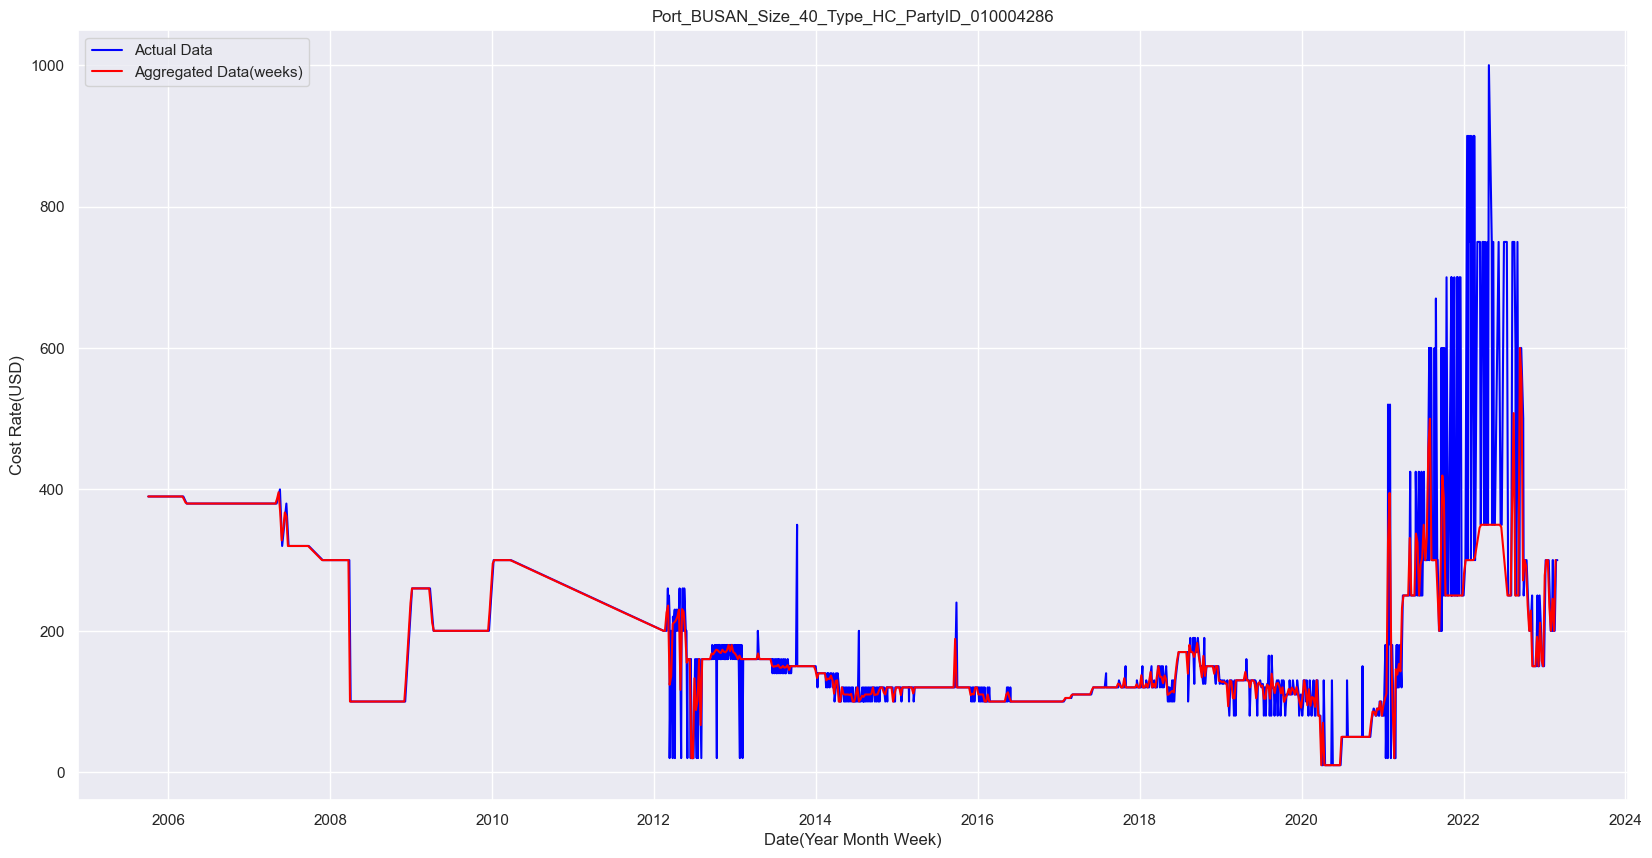

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'],
         color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show()


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [30]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest
# dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD']
                             > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


<h4>BI-LSTM Regression<h4>

In [31]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_BiLSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()

    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(Bidirectional(LSTM(units=lstm_layers[0], return_sequences=True, input_shape=(
                trainX.shape[1], trainX.shape[2]))))
            model.add(Dropout(0.2))

        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(Bidirectional(LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(
                0.01), return_sequences=False)))

        else:
            # Middle layers return sequences
            model.add(Bidirectional(LSTM(lstm_layers[i], return_sequences=True, activation='tanh',
                                        recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01))))
            model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.0005))
    
    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2,
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
5/5 - 56s - loss: 11.6298 - val_loss: 11.3059 - 56s/epoch - 11s/step
Epoch 2/50
5/5 - 0s - loss: 11.1318 - val_loss: 10.8191 - 341ms/epoch - 68ms/step
Epoch 3/50
5/5 - 0s - loss: 10.6514 - val_loss: 10.3504 - 340ms/epoch - 68ms/step
Epoch 4/50
5/5 - 0s - loss: 10.1893 - val_loss: 9.9001 - 340ms/epoch - 68ms/step
Epoch 5/50
5/5 - 0s - loss: 9.7458 - val_loss: 9.4684 - 344ms/epoch - 69ms/step
Epoch 6/50
5/5 - 0s - loss: 9.3207 - val_loss: 9.0551 - 341ms/epoch - 68ms/step
Epoch 7/50
5/5 - 0s - loss: 8.9139 - val_loss: 8.6598 - 341ms/epoch - 68ms/step
Epoch 8/50
5/5 - 0s - loss: 8.5249 - val_loss: 8.2820 - 338ms/epoch - 68ms/step
Epoch 9/50
5/5 - 0s - loss: 8.1530 - val_loss: 7.9211 - 339ms/epoch - 68ms/step
Epoch 10/50
5/5 - 0s - loss: 7.7980 - val_loss: 7.5765 - 341ms/epoch - 68ms/step
Epoch 11/50
5/5 - 0s - loss: 7.4589 - val_loss: 7.2475 - 339ms/epoch - 68ms/step
Epoch 12/50
5/5 -

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 1.0, 'Minimum validation loss by architecture and epoch')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Minimum Validation Loss')

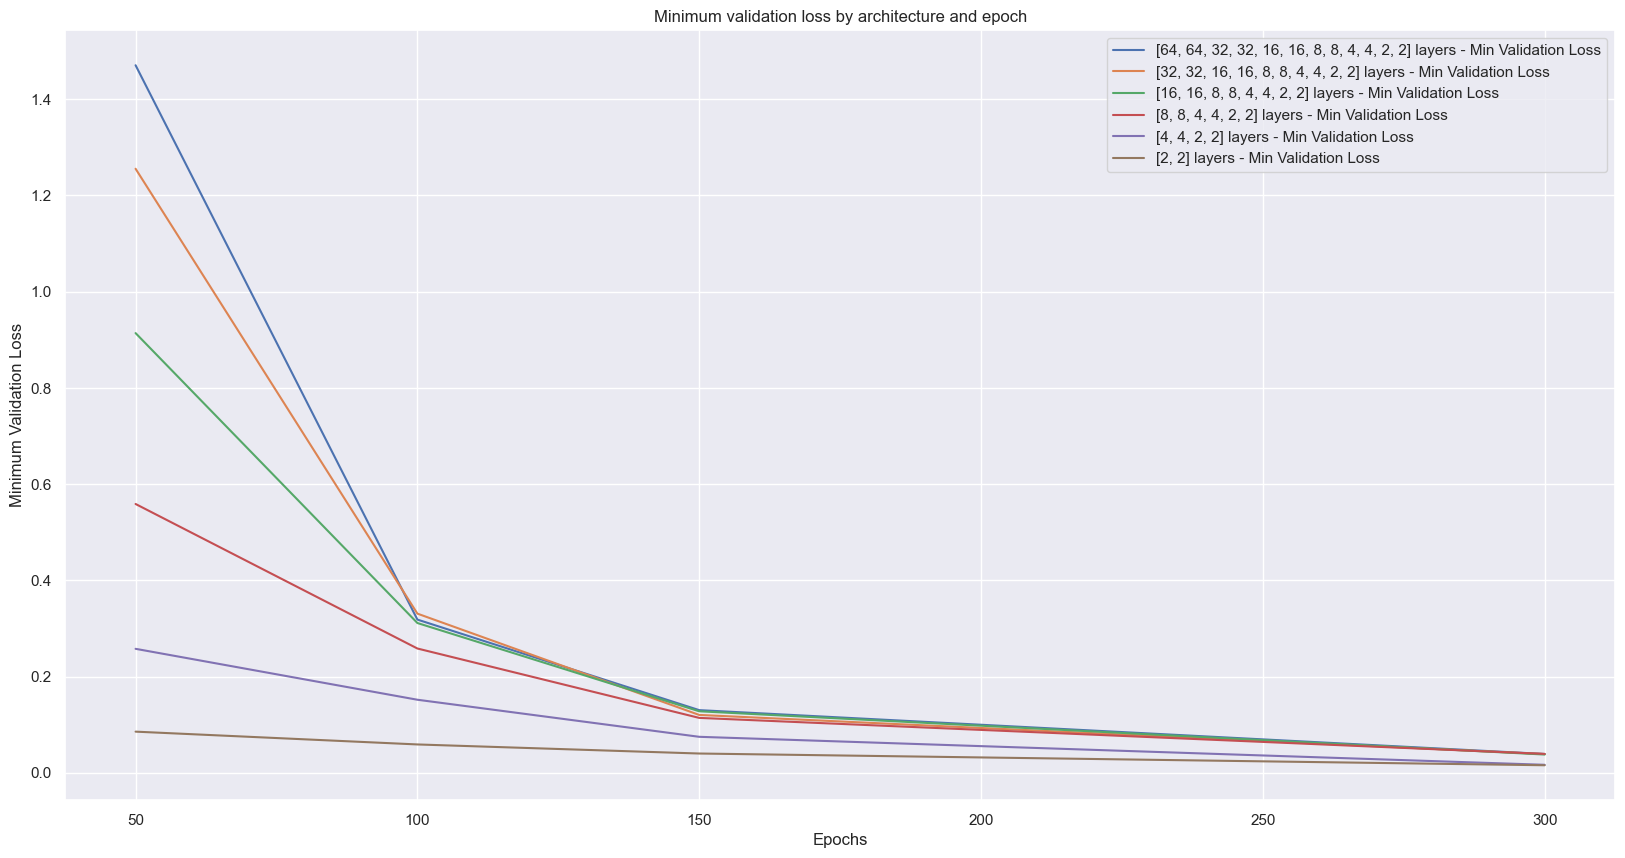

                                                    Train RMSE   Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...   97.498590  108.724110
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...   97.384543  108.989417
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers         97.040987  108.262747
50 epochs, [8, 8, 4, 4, 2, 2] layers                 96.565293  107.575929
50 epochs, [4, 4, 2, 2] layers                       93.759693  105.838419
50 epochs, [2, 2] layers                             56.914228   69.973020
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...   97.279913  109.533521
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...   97.301785  109.388075
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        97.262376  109.686777
100 epochs, [8, 8, 4, 4, 2, 2] layers                97.179459  109.166259
100 epochs, [4, 4, 2, 2] layers                      89.729384  103.512656
100 epochs, [2, 2] layers                            57.332528   72.392316
150 epochs, [64, 64, 32, 

In [32]:
# Initialize two separate scalers for normalization
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}  # store all rmse results
history_by_architecture = {} # store history archi

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_BiLSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)

        # Create a key for this architecture
        key = f'{lstm_layers} layers'
        if key not in history_by_architecture:
            # Initialize the dictionary for this architecture
            history_by_architecture[key] = {
                'epochs': [],
                'min_val_loss': []
            }

        # Append the number of epochs and the minimum validation loss
        history_by_architecture[key]['epochs'].append(epochs)
        history_by_architecture[key]['min_val_loss'].append(min(history.history['val_loss']))

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler_rate.inverse_transform(trainPredict)
        trainY_orig = scaler_rate.inverse_transform([trainY])
        testPredict = scaler_rate.inverse_transform(testPredict)
        testY_orig = scaler_rate.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:, 0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:, 0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {
            'Train RMSE': trainScore, 'Test RMSE': testScore}

# Now plot the histories
plt.figure(figsize=(20, 10))
for key, val in history_by_architecture.items():
    plt.plot(val['epochs'], val['min_val_loss'], label=f'{key} - Min Validation Loss')

plt.title('Minimum validation loss by architecture and epoch')
plt.xlabel('Epochs')
plt.ylabel('Minimum Validation Loss')
plt.legend()
plt.show()

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

<h4>Forecast the results</h4>

In [33]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100


def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values_scaled = scaler.transform(last_values_2d)
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        prediction = model.predict(input_values_scaled)
        prediction = scaler.inverse_transform(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast


In [34]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(
    model, look_back, scaler_rate, last_values, weeks)
forecasted_dates = pd.date_range(
    start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()


1/1 [==============================] - 0s 21ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,POD,RATE
0,2023-03-05,222.110001
1,2023-03-12,220.479996
2,2023-03-19,234.300003
3,2023-03-26,231.029999
4,2023-04-02,248.449997


,POD,RATE
7,2023-04-23,229.470001
8,2023-04-30,228.770004
9,2023-05-07,229.199997
10,2023-05-14,221.039993
11,2023-05-21,222.770004


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [35]:
comparison_df = pd.DataFrame(
    columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (
        new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(
    subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_2856\2511611426.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\U

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-03-05,2023-03-12,2023-03-08,222.110001,260.0,85.426923
1,2023-03-12,2023-03-19,2023-03-15,220.479996,260.0,84.799998
2,2023-03-19,2023-03-26,2023-03-19,234.300003,300.0,78.100001
3,2023-03-26,2023-04-02,2023-03-26,231.029999,260.0,88.857692
4,2023-03-26,2023-04-02,2023-04-01,231.029999,260.0,88.857692
5,2023-04-02,2023-04-09,2023-04-08,248.449997,260.0,95.557691
6,2023-04-09,2023-04-16,2023-04-12,222.000000,300.0,74.000000
7,2023-04-09,2023-04-16,2023-04-15,222.000000,260.0,85.384615
8,2023-04-16,2023-04-23,2023-04-20,224.889999,260.0,86.496154
9,2023-04-23,2023-04-30,2023-04-26,229.470001,300.0,76.490000


The mean accuracy is 84.11%



In [36]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_178 (Bidirect  (None, 5, 4)             64        
 ional)                                                          
                                                                 
 dropout_154 (Dropout)       (None, 5, 4)              0         
                                                                 
 bidirectional_179 (Bidirect  (None, 4)                112       
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


<h4>Visualise all, Conclusion</h4>

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date(Year Month)')

Text(0, 0.5, 'Cost Rate(USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

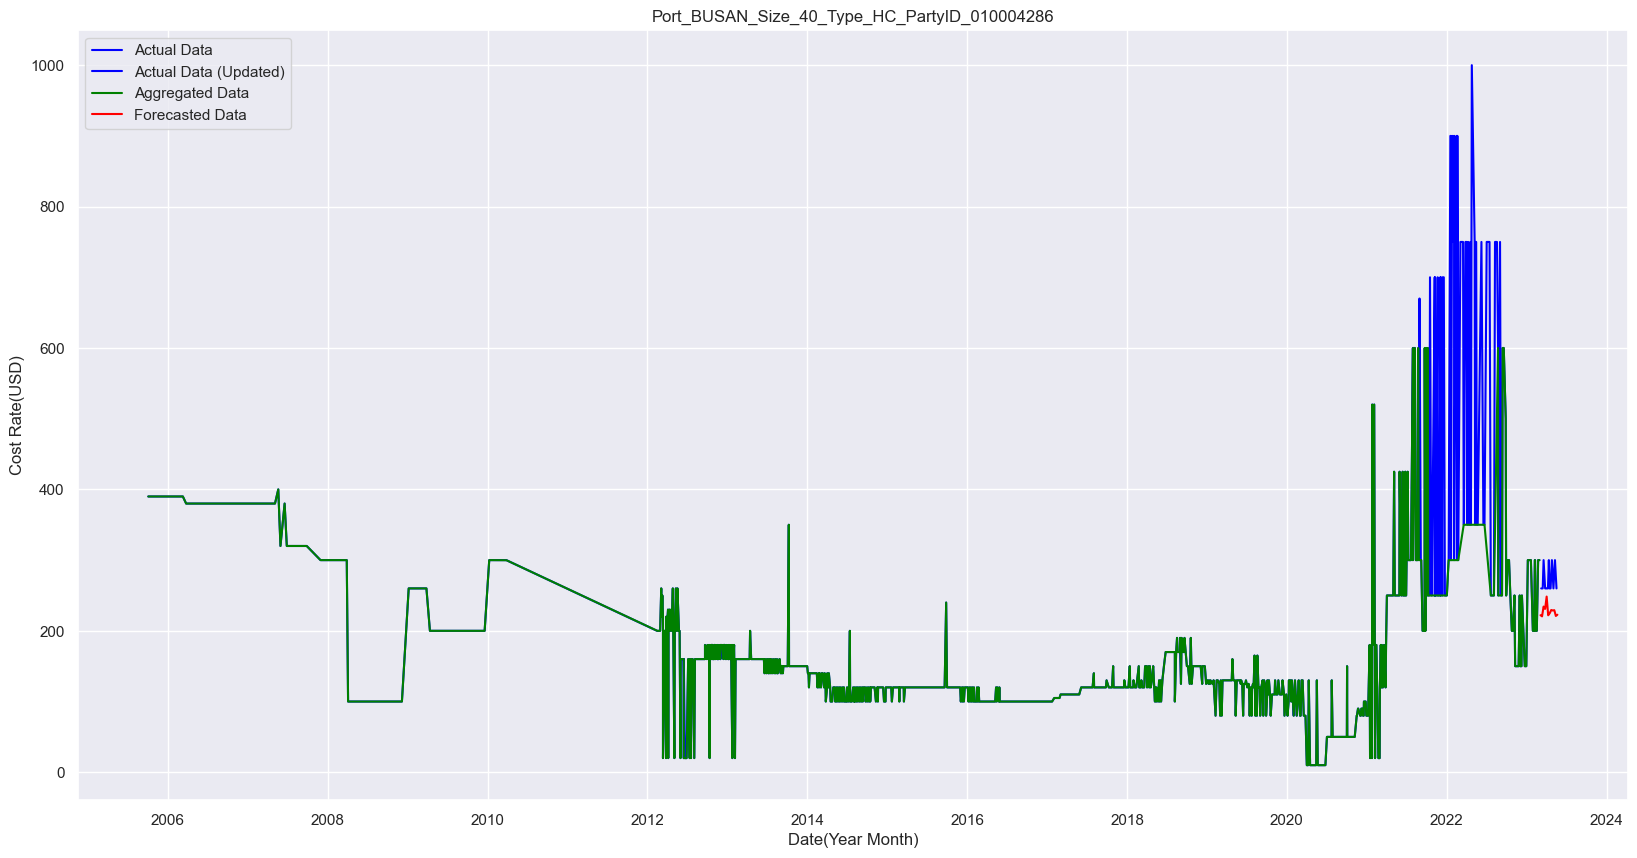

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'],
         color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'],
         color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'],
         color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show()


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Date (Year Month)')

Text(0, 0.5, 'Cost Rate (USD)')

Text(0.5, 1.0, 'Port_BUSAN_Size_40_Type_HC_PartyID_010004286')

(17532.0, 19723.0)

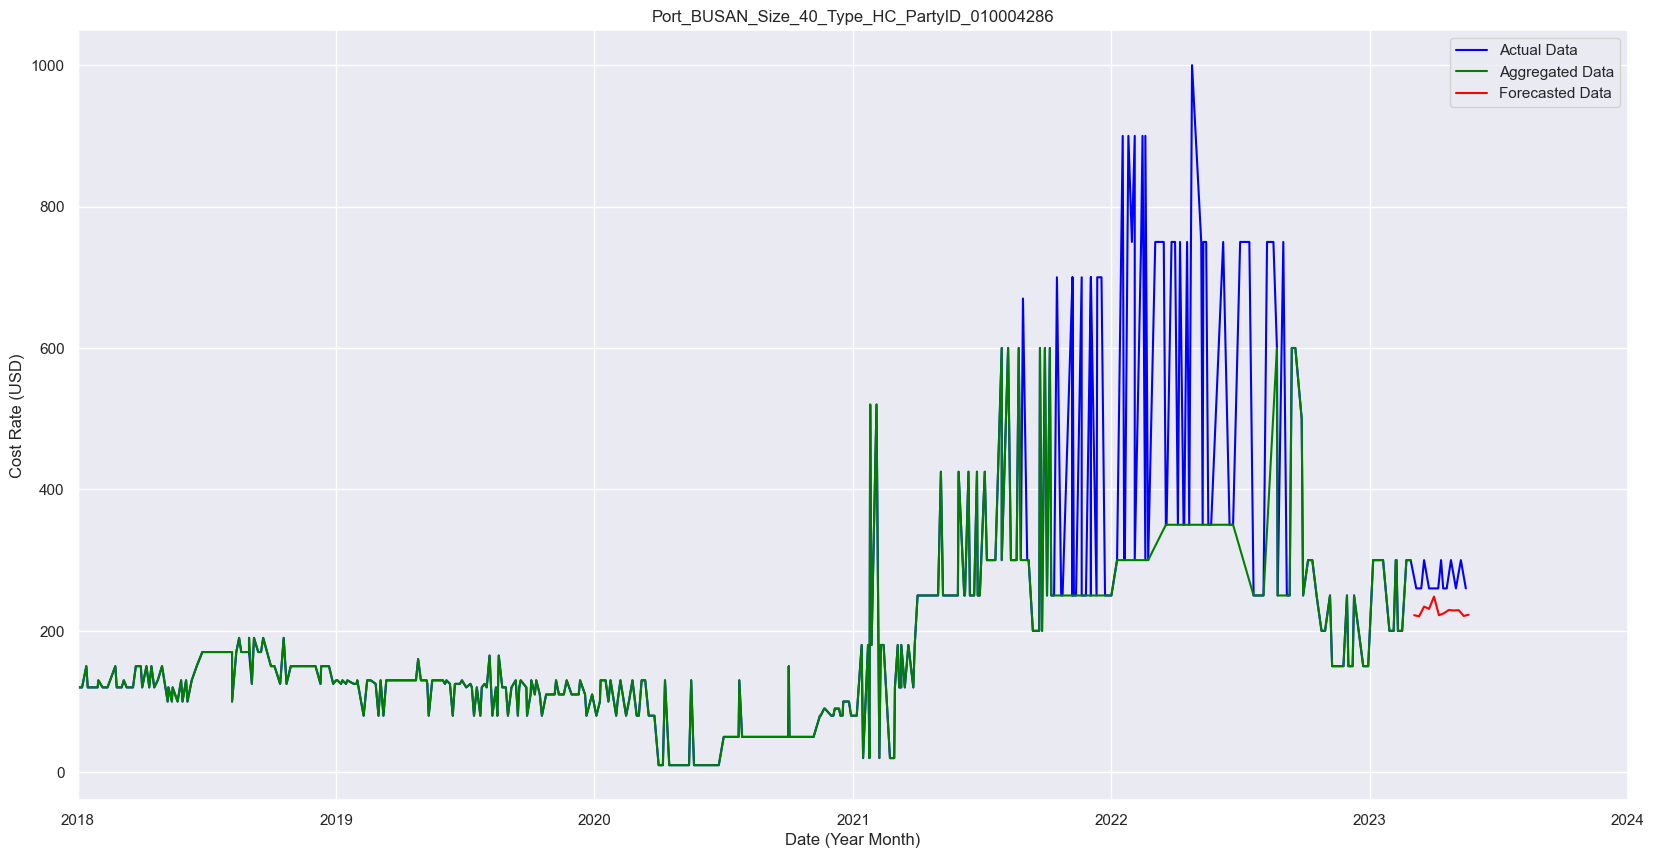

In [38]:
from matplotlib.dates import datestr2num

# Define the start and end dates of the desired range
start_date = '2018-01-01'
end_date = '2024-01-01'

# Convert the date strings to numeric values
start_num = datestr2num(start_date)
end_num = datestr2num(end_date)

# Concatenate sel_df and new_dates_df
merged_df = pd.concat([sel_df, new_dates_df])

# Sort the merged data by 'POD'
merged_df.sort_values('POD', inplace=True)

# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(merged_df['POD'], merged_df['RATE'], color='blue', label="Actual Data")
plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date (Year Month)')
plt.ylabel('Cost Rate (USD)')
plt.title(sel_country)
plt.legend()

# Set the x-axis limits using the converted numeric values
plt.xlim(start_num, end_num)
plt.show()